If you are running this notebook on Google Colab, you can mount your Google Drive to save the data and load them later. To do this, uncomment the following code and follow the instructions.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
%pip install medmnist
%pip install tensorflow==2.15.0
%pip install matplotlib
%pip install lime
%pip install tf-explain
%pip install opencv-python

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, f1_score, classification_report
import matplotlib.pyplot as plt
import os
from medmnist.dataset import PneumoniaMNIST
import random
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries
import matplotlib.cm as cm
import cv2

2024-04-20 16:37:37.956888: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-20 16:37:38.007951: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-20 16:37:38.008012: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-20 16:37:38.009792: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-20 16:37:38.019506: I tensorflow/core/platform/cpu_feature_guar

In [4]:
# os.environ['TF_DETERMINISTIC_OPS'] = '1'
# tf.config.experimental.enable_op_determinism()
kseed=0
np.random.seed(kseed)
random.seed(kseed)
tf.random.set_seed(kseed)
tf.keras.utils.set_random_seed(kseed)

In [5]:
input_root = '/home/biosim/Fanis/ISBI'
output_root = os.path.join(input_root, 'PneumoniaMNIST')
if not os.path.isdir(output_root):
    os.makedirs(output_root)

In [6]:
_ = PneumoniaMNIST(split="train", root=input_root, download=True, size=224)

Using downloaded and verified file: /home/biosim/Fanis/ISBI/pneumoniamnist_224.npz


In [7]:
npz_file = np.load(os.path.join(input_root, "pneumoniamnist_224.npz"))

x_train = npz_file['train_images']
x_train = np.repeat(x_train[..., np.newaxis], 3, axis=-1)
y_train = npz_file['train_labels']

x_val = npz_file['val_images']
x_val = np.repeat(x_val[..., np.newaxis], 3, axis=-1)
y_val = npz_file['val_labels']

x_test = npz_file['test_images']
x_test = np.repeat(x_test[..., np.newaxis], 3, axis=-1)
y_test = npz_file['test_labels']

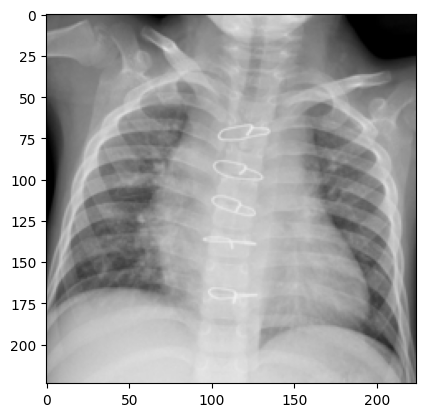

In [8]:
plt.imshow(x_train[0])

In [9]:
def create_model(pooling='max', lr=0.001):
    """
    This function creates a ResNet50 model.

    Parameters:
    pooling (str): the type of global pooling to be applied, default is 'max'
    lr (float): learning rate, default is 0.001

    Returns:
    model (tf.keras.models.Model): the compiled model
    """
    tf.keras.backend.clear_session()

    i = tf.keras.layers.Input([224, 224, 3], dtype="uint8")
    x = tf.keras.layers.Lambda(lambda x: tf.cast(x, "float32"))(i)
    preprocess_input = tf.keras.applications.resnet_v2.preprocess_input(x)

    pretrained_model = tf.keras.applications.ResNet50V2(include_top=False, pooling=pooling, weights='imagenet', input_tensor=preprocess_input)

    x = pretrained_model.output
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    out = tf.keras.layers.Dense(2, activation='softmax')(x)
    model = tf.keras.models.Model(i, outputs=out)
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='CategoricalCrossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall'),
                           tf.keras.metrics.AUC(name='auc'),
                           tf.keras.metrics.AUC(curve='PR', name='auprc')]
                  )
    return model

In [10]:
model = create_model()

2024-04-20 16:37:51.547181: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-20 16:37:51.549392: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-20 16:37:51.549844: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 lambda (Lambda)             (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)          0         ['lambda[0][0]']              
 a)                                                                                               
                                                                                                  
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)          0         ['tf.math.truediv[0][0]'] 

In [11]:
# y_train_one = tf.keras.utils.to_categorical(y_train)
# y_val_one = tf.keras.utils.to_categorical(y_val)
# history = model.fit(x_train, y_train_one, epochs=100, validation_data=(x_val, y_val_one),
#                     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_auc',
#                                                                 mode='max',
#                                                                 patience=30,
#                                                                 verbose=1,
#                                                                 restore_best_weights=True)]
#                     )

In [12]:
# model.save_weights(os.path.join(input_root, 'model.weights.h5'))

In [13]:
model.load_weights(os.path.join(input_root, 'model.weights.h5'))

In [23]:
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_labels)
roc_auc = roc_auc_score(y_test, y_pred[:, 1])
f1 = f1_score(y_test, y_pred_labels)
confusion = confusion_matrix(y_test, y_pred_labels)

print("Confusion Matrix:")
print(confusion)

print("Accuracy: ", accuracy)
print("ROC AUC: ", roc_auc)
print("F1 Score: ", f1)

20/20 [==============================] - 1s 51ms/step
Confusion Matrix:
[[170  64]
 [  2 388]]
Accuracy:  0.8942307692307693
ROC AUC:  0.9796789392943239
F1 Score:  0.9216152019002375


In [15]:
# Initialize lists to hold the indices of each category
true_positives = []
true_negatives = []
false_positives = []
false_negatives = []

# Iterate over the test set and categorize each image
for i in range(len(y_test)):
    # True positives
    if y_test[i] == 1 and y_pred_labels[i] == 1:
        true_positives.append(i)
    # True negatives
    elif y_test[i] == 0 and y_pred_labels[i] == 0:
        true_negatives.append(i)
    # False positives
    elif y_test[i] == 0 and y_pred_labels[i] == 1:
        false_positives.append(i)
    # False negatives
    elif y_test[i] == 1 and y_pred_labels[i] == 0:
        false_negatives.append(i)

# Select one image from each category
tn_i = true_negatives[np.random.randint(len(true_negatives))]
fn_i = false_negatives[np.random.randint(len(false_negatives))]
fp_i = false_positives[np.random.randint(len(false_positives))]
tp_i = true_positives[np.random.randint(len(true_positives))]

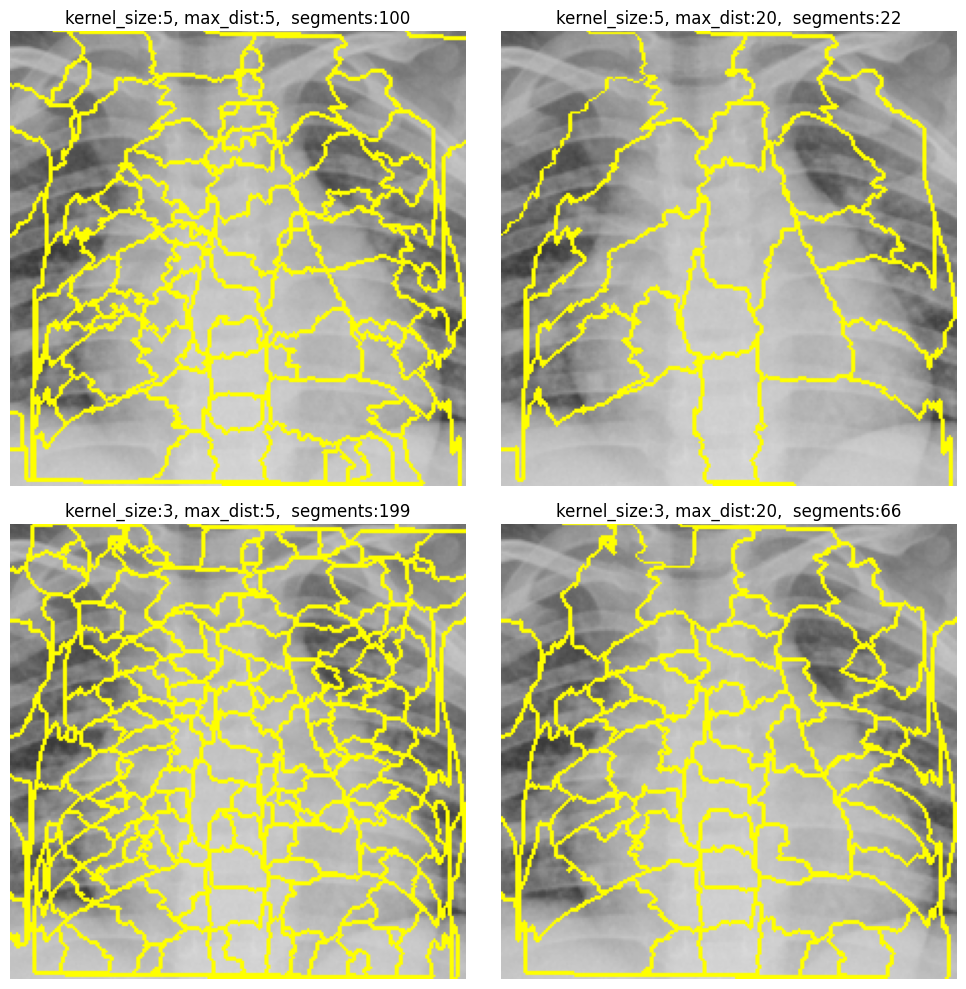

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

for i, seg_args in enumerate([{'kernel_size':5, 'max_dist':5},
                           {'kernel_size':5, 'max_dist':20},
                           {'kernel_size':3, 'max_dist':5},
                           {'kernel_size':3, 'max_dist':20}]):

    segments = SegmentationAlgorithm('quickshift', **seg_args, ratio=0.2)(x_test[tn_i, ...])

    ax[i//2, i%2].imshow(mark_boundaries(x_test[tp_i, ...], segments))
    ax[i//2, i%2].set_title(f'kernel_size:{seg_args["kernel_size"]}, max_dist:{seg_args["max_dist"]},  segments:{len(np.unique(segments))}')
    

    for a in ax.ravel():
        a.set_axis_off()

plt.tight_layout()
plt.show()

In [17]:
def display_lime(image, samples, axs):
    explainer = lime_image.LimeImageExplainer(verbose=True)
    explanation = explainer.explain_instance(image=image, top_labels=1, batch_size=100,
                                             classifier_fn=lambda x: model.predict(x, verbose=0), num_samples=samples,
                                             segmentation_fn=SegmentationAlgorithm('quickshift', kernel_size=3, max_dist=20, ratio=0.2))

    _, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
    heatmap = np.vectorize(dict(explanation.local_exp[explanation.top_labels[0]]).get)(explanation.segments)*np.abs(mask)

    axs.imshow(mark_boundaries(image, explanation.segments))
    axs.imshow(heatmap, cmap = 'PiYG', vmin  = -np.abs(heatmap).max(), vmax = np.abs(heatmap).max(), alpha=0.5)
    
    axs.axis('off')

  0%|          | 0/100 [00:00<?, ?it/s]

Intercept 0.9999996948877007
Prediction_local [1.00000004]
Right: 1.0


  0%|          | 0/100 [00:00<?, ?it/s]

Intercept 0.999999759525857
Prediction_local [0.99999989]
Right: 1.0


  0%|          | 0/100 [00:00<?, ?it/s]

Intercept 0.9999997443483011
Prediction_local [0.99999998]
Right: 1.0


  0%|          | 0/100 [00:00<?, ?it/s]

Intercept 0.9999995756138225
Prediction_local [0.99999999]
Right: 1.0


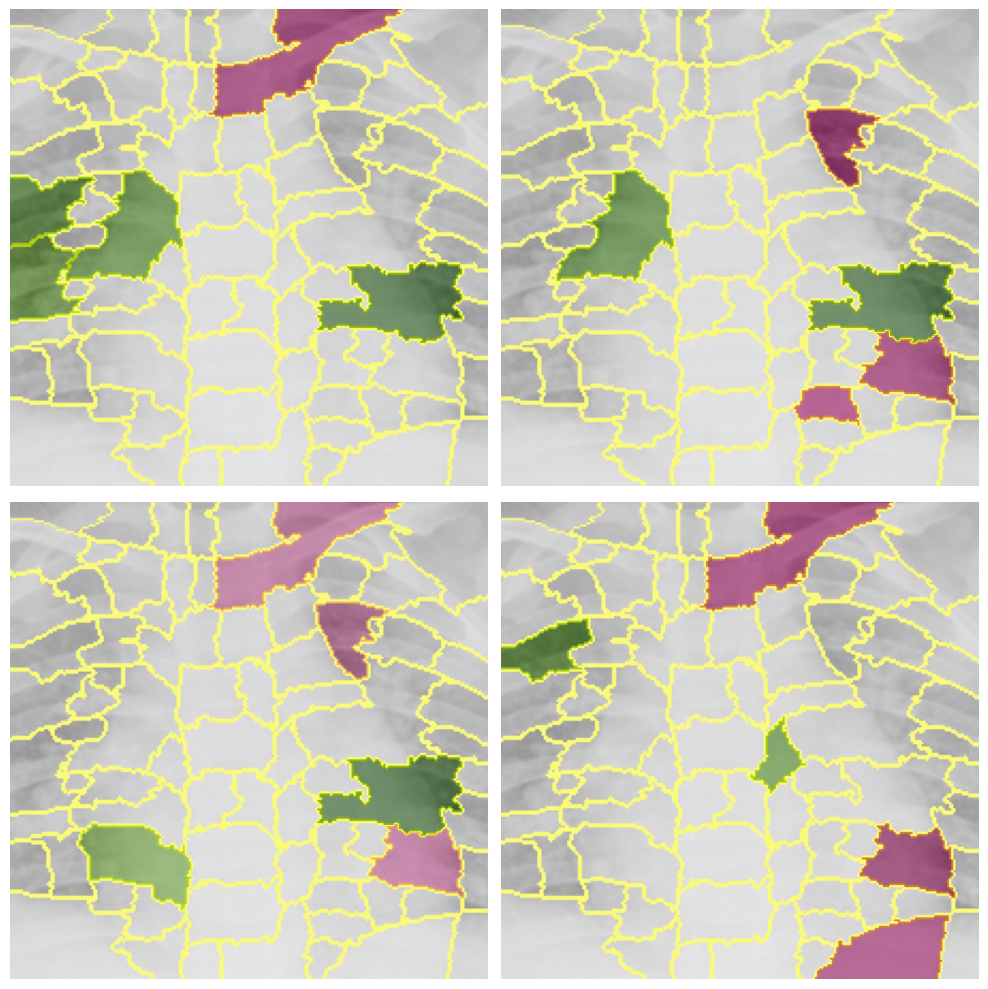

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # Create a 2x2 grid of subplots
axs = axs.ravel()  # Flatten the grid to easily iterate over it

for i in range(4):
    display_lime(x_test[tp_i, ...], 100, axs[i])

plt.tight_layout()
plt.show()

  0%|          | 0/6000 [00:00<?, ?it/s]

Intercept 0.999999614362395
Prediction_local [1.00000007]
Right: 1.0


  0%|          | 0/6000 [00:00<?, ?it/s]

Intercept 0.9999996366645192
Prediction_local [1.00000004]
Right: 1.0


  0%|          | 0/6000 [00:00<?, ?it/s]

Intercept 0.9999996326678338
Prediction_local [1.00000004]
Right: 1.0


  0%|          | 0/6000 [00:00<?, ?it/s]

Intercept 0.9999995687692051
Prediction_local [1.00000012]
Right: 1.0


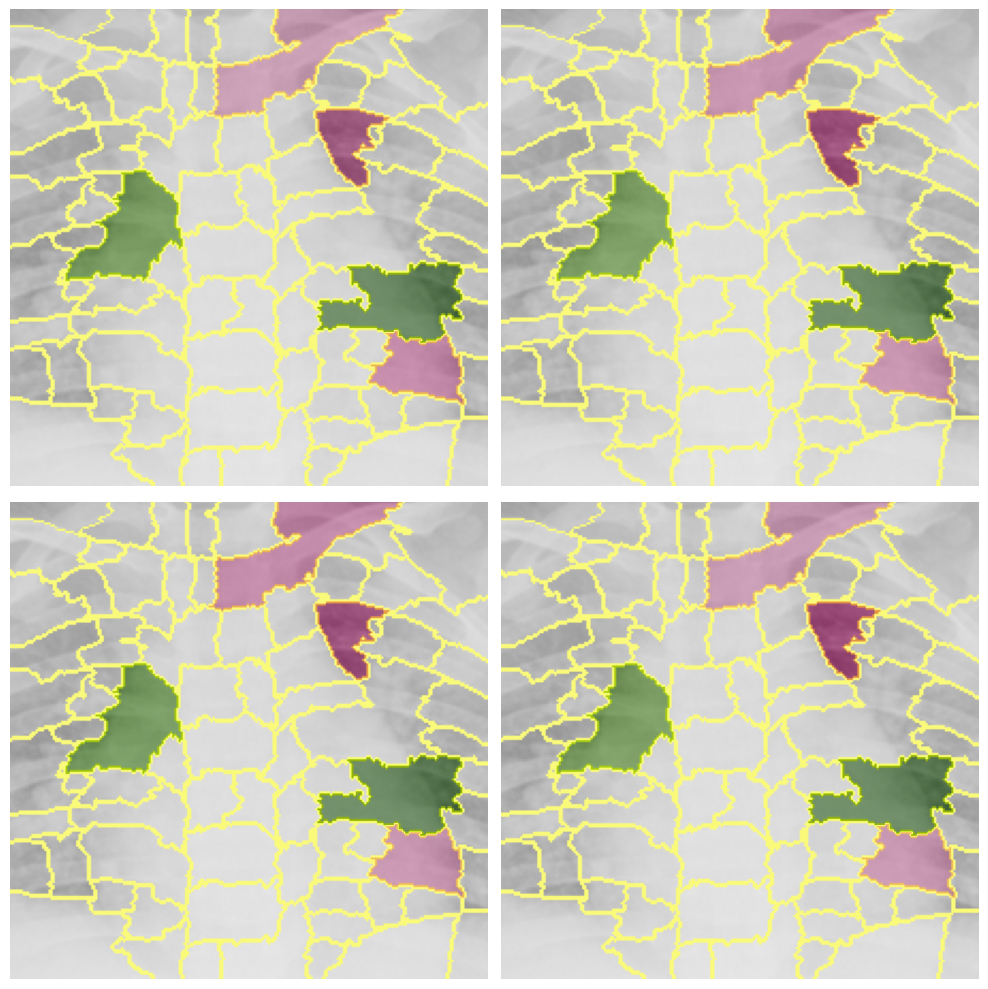

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # Create a 2x2 grid of subplots
axs = axs.ravel()  # Flatten the grid to easily iterate over it

for i in range(4):
    display_lime(x_test[tp_i, ...], 6000, axs[i])

plt.tight_layout()
plt.show()

  0%|          | 0/6000 [00:00<?, ?it/s]

Intercept 0.9927727542552591
Prediction_local [1.0045585]
Right: 0.9999908


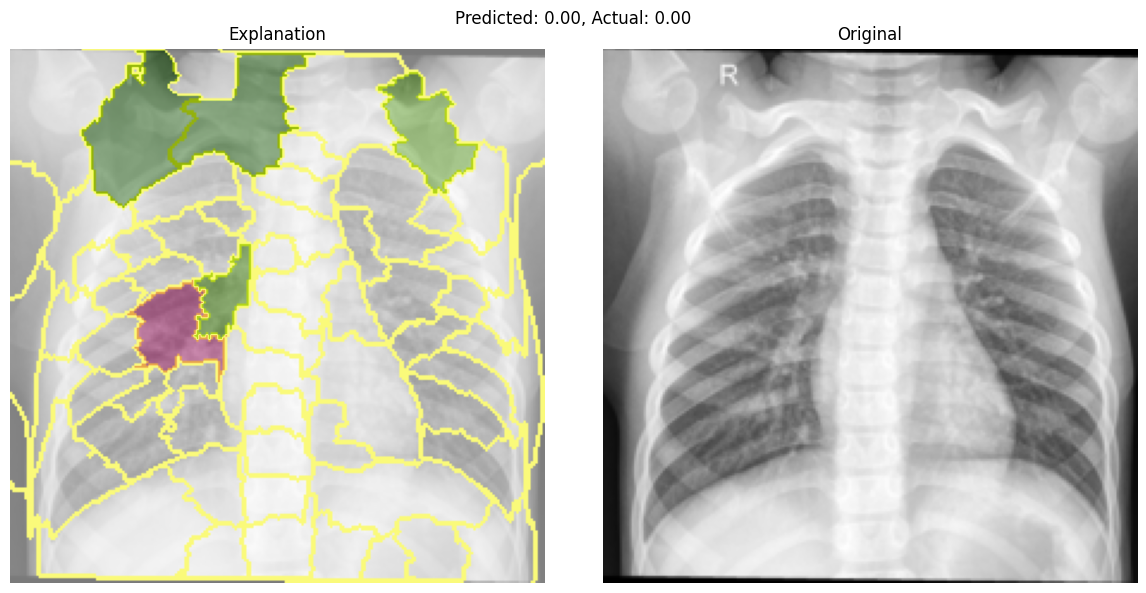

  0%|          | 0/6000 [00:00<?, ?it/s]

Intercept 0.9999996485038507
Prediction_local [1.00000003]
Right: 1.0


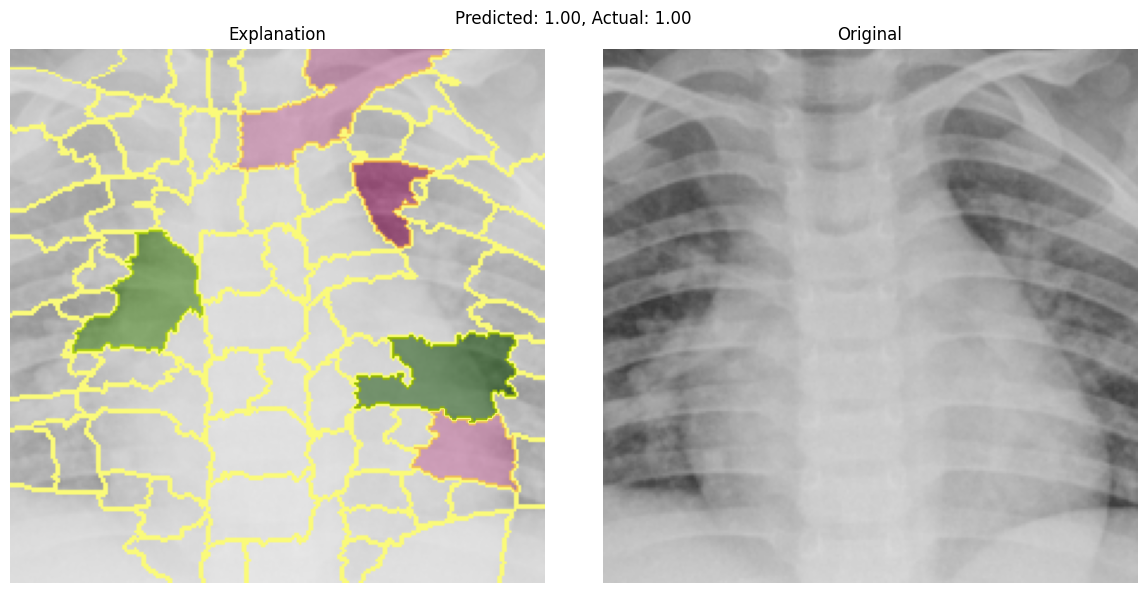

  0%|          | 0/6000 [00:00<?, ?it/s]

Intercept 0.9974770416643921
Prediction_local [1.00053059]
Right: 0.9999989


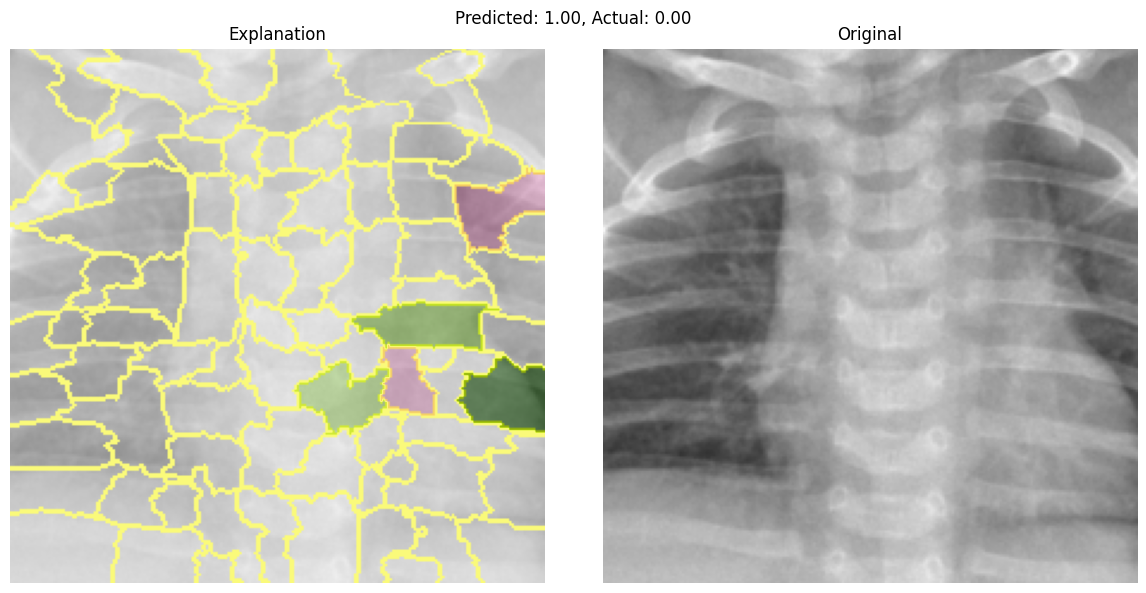

  0%|          | 0/6000 [00:00<?, ?it/s]

Intercept 0.10936342028720875
Prediction_local [0.8581929]
Right: 0.8417838


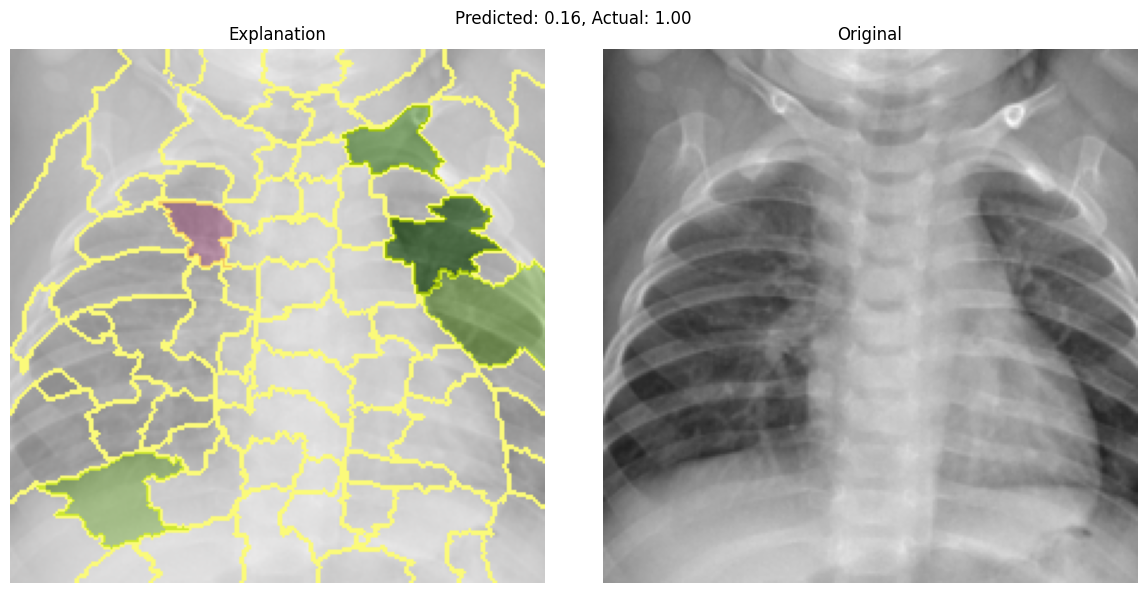

In [20]:
for i, image_i in enumerate([tn_i, tp_i, fp_i, fn_i]):
    
    preds = model.predict(x_test[image_i:image_i+1, ...], verbose=0)
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Create a 2x2 grid of subplots
    fig.suptitle(f'Predicted: {np.squeeze(preds[:, 1]):.2f}, Actual: {np.squeeze(y_test[image_i]):.2f}')

    display_lime(x_test[image_i, ...], 6000, axs[0])
    
    axs[1].imshow(x_test[image_i, ...])
    axs[1].axis('off')    
    
    axs[0].set_title('Explanation')
    axs[1].set_title('Original')
    
    plt.tight_layout()
    plt.show()

In [21]:
def make_gradcam_heatmap(img_array, model, pred_index=None):
    """
    This function generates a Grad-CAM heatmap for a given image.

    Parameters:
    img_array (np.array): the input image
    model (tf.keras.models.Model): the model
    pred_index (int): the index of the class to visualize

    Returns:
    heatmap (np.array): the generated heatmap
    """
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer('post_relu').output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img, heatmap, ax, alpha=0.4):
    """
    This function displays a Grad-CAM heatmap on an image.

    Parameters:
    img (np.array): the input image
    heatmap (np.array): the heatmap to display
    ax (matplotlib.axes.Axes): the axes to plot on
    alpha (float): the transparency of the heatmap
    """
    ax.imshow(np.flipud(img))
    ax.axis('off')
    i = ax.imshow(heatmap, alpha=alpha, cmap='jet', interpolation='bilinear', extent=(0, img.shape[1], 0, img.shape[0]))
    plt.colorbar(i, ax=ax)

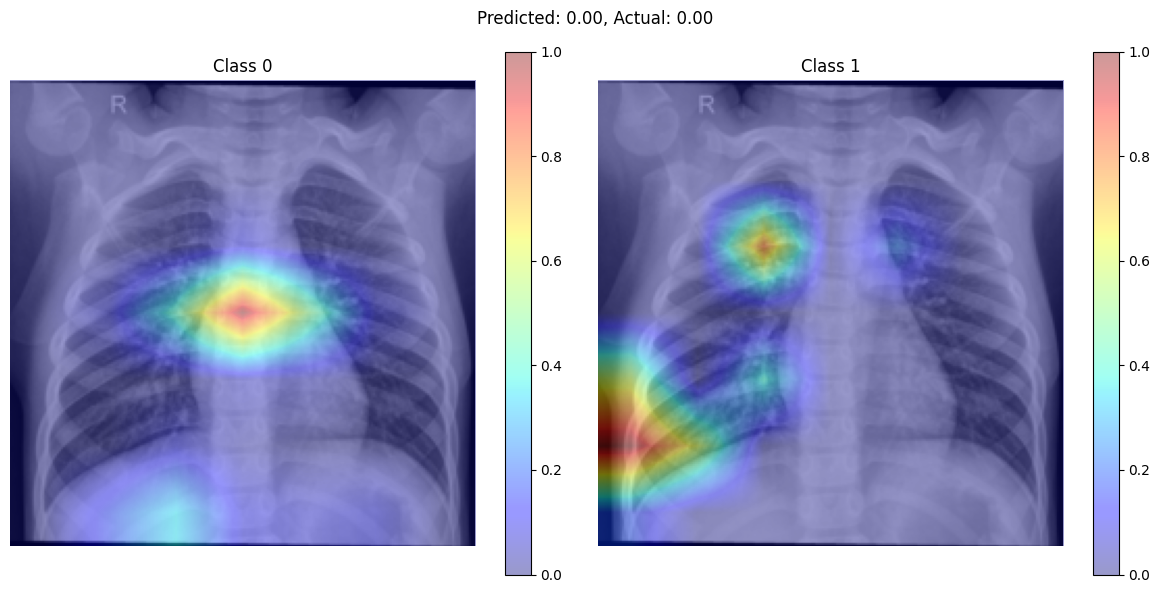

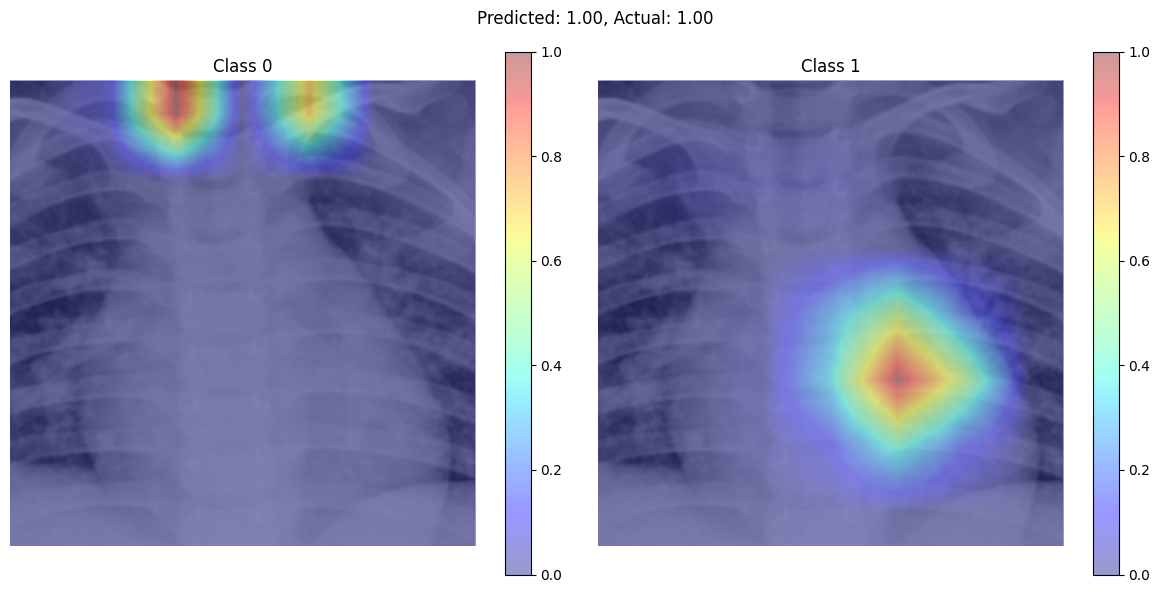

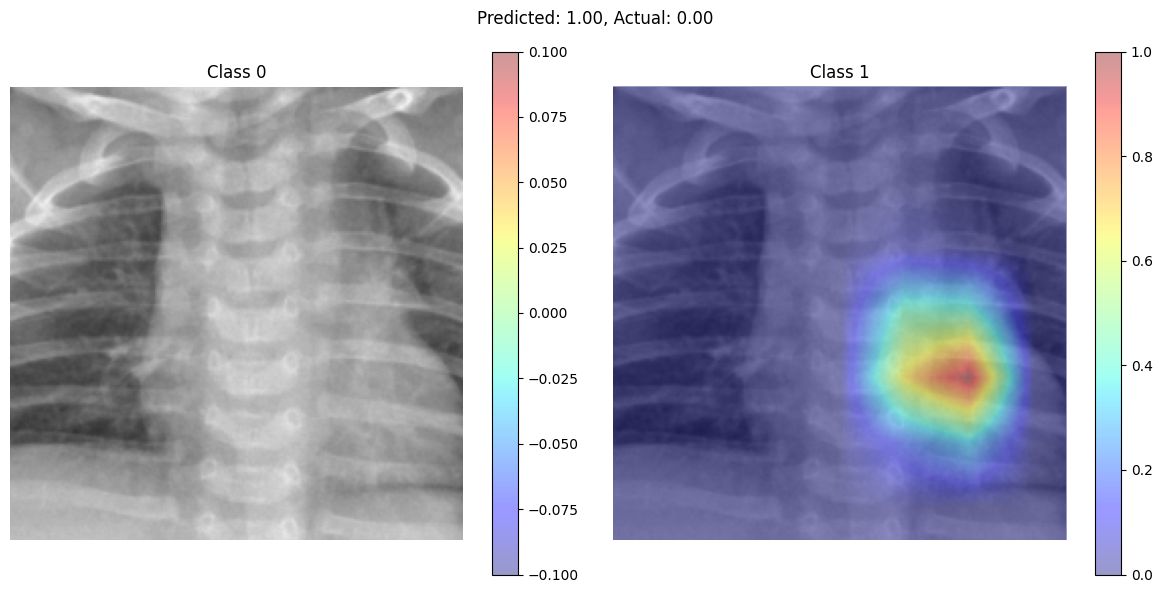

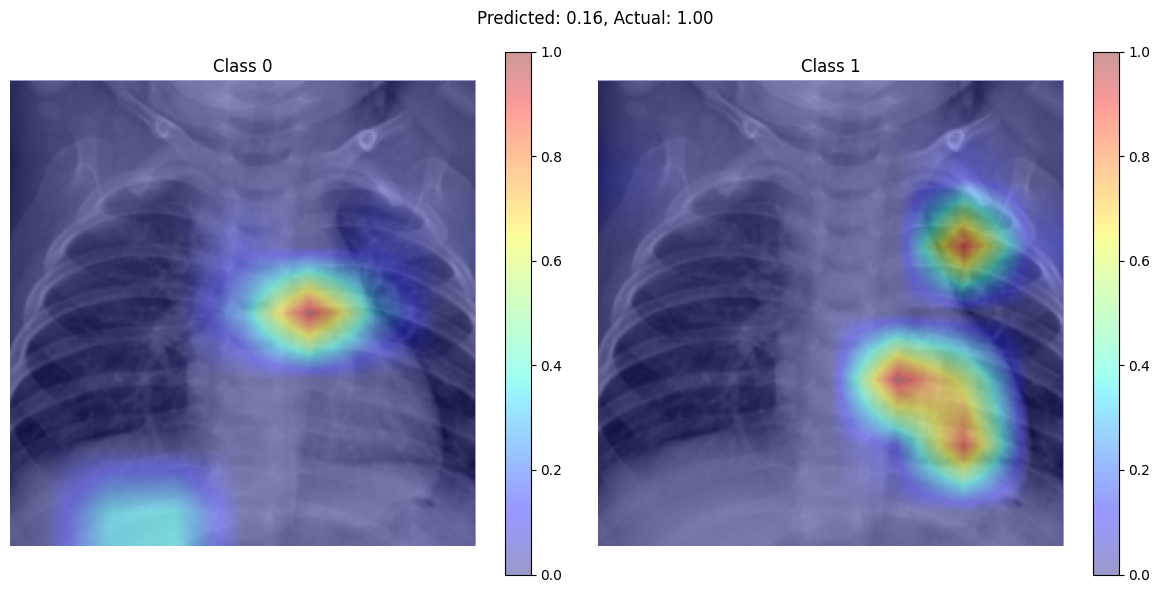

In [22]:
model.layers[-1].activation = None
for i, image_i in enumerate([tn_i, tp_i, fp_i, fn_i]):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Create a 2x2 grid of subplots
    
    preds = model.predict(x_test[image_i:image_i+1, ...], verbose=0)
    fig.suptitle(f'Predicted: {np.squeeze(preds[:, 1]):.2f}, Actual: {np.squeeze(y_test[image_i]):.2f}')
    
    heatmap = make_gradcam_heatmap(x_test[image_i:image_i+1, ...], model, pred_index=0)
    display_gradcam(x_test[image_i, ...], heatmap, axs[0])
    axs[0].set_title('Class 0')

    heatmap = make_gradcam_heatmap(x_test[image_i:image_i+1, ...], model, pred_index=1)
    display_gradcam(x_test[image_i, ...], heatmap, axs[1])
    axs[1].set_title('Class 1')
    plt.tight_layout()
    plt.show()